# Лабораторна робота №4

## Тема

Згорткові мережі та робота з зображеннями.

## Мета

отримати навички реалізації згорткової мережі та методу
перенесення навчання.

## Автор

Молчанов Михайло, ІА-12

## Виконання

### Завантаження та підготовка даних

1. **Функція `load_images_from_directory`:**
   - Завантажує зображення з вказаних директорій.
   - Змінює розмір зображень до заданих параметрів `img_size` (128x128 пікселів).
   - Прив’язує мітки (`labels`) до класів (`cats` та `dogs`), використовуючи мапу `class_mapping`.

2. **Мапа класів (`class_mapping`):**
   - Визначено вручну: `{'cats': 0, 'dogs': 1}` для узгодженості.

3. **Нормалізація даних:**
   - Значення пікселів масштабуються до діапазону `[0, 1]`, ділячи на `255.0`.

4. **Візуалізація даних:**
   - Відображено випадкові зразки з навчального набору разом із назвами класів.

Training data shape: (20000, 128, 128, 3), Labels shape: (20000,)
Validation data shape: (2490, 128, 128, 3), Labels shape: (2490,)
Test data shape: (2500, 128, 128, 3), Labels shape: (2500,)
Class mapping: {'cats': 0, 'dogs': 1}


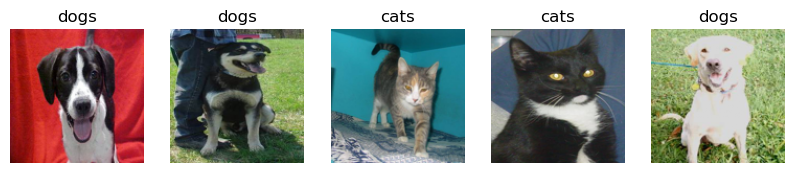

In [20]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Paths to data directories
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Parameters
img_size = (128, 128)

def load_images_from_directory(directory, target_size, class_mapping=None):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    
    if class_mapping is None:
        # Automatically create a mapping based on class names
        class_mapping = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            try:
                # Load and resize image
                img = Image.open(file_path).convert('RGB')
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(class_mapping[class_name])
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")
    
    return np.array(images), np.array(labels), class_mapping

# Define the class mapping manually for consistency
class_mapping = {'cats': 0, 'dogs': 1}

# Load the train, validation, and test sets
x_train, y_train, _ = load_images_from_directory(train_dir, img_size, class_mapping)
x_val, y_val, _ = load_images_from_directory(val_dir, img_size, class_mapping)
x_test, y_test, _ = load_images_from_directory(test_dir, img_size, class_mapping)

# Normalize images
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Check loaded data
print(f"Training data shape: {x_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {x_test.shape}, Labels shape: {y_test.shape}")
print(f"Class mapping: {class_mapping}")

# Visualize a few samples
def visualize_samples(images, labels, class_mapping, num_samples=5):
    reverse_mapping = {v: k for k, v in class_mapping.items()}
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(reverse_mapping[labels[idx]])
        plt.axis('off')
    plt.show()

# Visualize training samples
visualize_samples(x_train, y_train, class_mapping)


#### Результати:
1. **Форми даних:**
   - **Навчальний набір:** `(20000, 128, 128, 3)` (20,000 зображень).
   - **Валідаційний набір:** `(2490, 128, 128, 3)` (2,490 зображень).
   - **Тестовий набір:** `(2500, 128, 128, 3)` (2,500 зображень).
   - **Мапа класів:** `{'cats': 0, 'dogs': 1}`.

2. **Приклад зображень:**
   - Наведено приклади з класів "cats" та "dogs", щоб візуально перевірити правильність завантаження даних.

#### Візуалізація:

На наведеному графіку зображено кілька вибіркових прикладів із набору даних разом із відповідними мітками класів. 


### Перевірка унікальних міток та їх розподілу

#### Опис:
На цьому етапі перевірено кількість унікальних міток у навчальному наборі даних та підраховано їхній розподіл. Це дозволяє переконатися в збалансованості даних між двома класами: "cats" (мітка `0`) і "dogs" (мітка `1`).


In [21]:
# Check unique labels and their counts
unique, counts = np.unique(y_train, return_counts=True)
print(f"Labels in training set: {dict(zip(unique, counts))}")


Labels in training set: {0: 10000, 1: 10000}


#### Результат:
- Унікальні мітки: `0`, `1`.
- Розподіл міток у навчальному наборі:
  - **"cats" (`0`)**: `10,000` зображень.
  - **"dogs" (`1`)**: `10,000` зображень.

#### Висновок:
Набір даних є ідеально збалансованим, що позитивно вплине на навчання моделей, оскільки кожен клас має однакову кількість зразків.

### Покращена повнозв’язна нейронна мережа (Fully Connected Model)

#### Опис:
На цьому етапі було побудовано покращену повнозв’язну модель з трьома блоками щільних шарів (Dense), які включають нормалізацію (Batch Normalization) і регуляризацію (Dropout). Це було зроблено для зменшення переобладнання (overfitting) і покращення здатності моделі до узагальнення.

- Використані блоки:
  - **Перший блок**: 256 нейронів, активація ReLU, Batch Normalization, Dropout (0.5).
  - **Другий блок**: 128 нейронів, активація ReLU, Batch Normalization, Dropout (0.5).
  - **Третій блок**: 64 нейрони, активація ReLU, Dropout (0.4).
  - **Вихідний шар**: 1 нейрон з сигмоїдальною активацією для бінарної класифікації.

- **Кількість епох**: 20.
- **Розмір пакету**: 32.

In [27]:
from keras.api.models import Sequential
from keras.api.layers import Flatten, Dense, Dropout, BatchNormalization

# Enhanced Fully Connected Model
dense_model = Sequential([
    Flatten(input_shape=img_size + (3,)),  # Flatten input images
    
    # First dense block
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Second dense block
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Third dense block
    Dense(64, activation='relu'),
    Dropout(0.4),
    
    # Output layer
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
dense_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_dense = dense_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,  # Increased number of epochs
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = dense_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5307 - loss: 0.8312 - val_accuracy: 0.5948 - val_loss: 0.6662
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5775 - loss: 0.6827 - val_accuracy: 0.5900 - val_loss: 0.6644
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6019 - loss: 0.6639 - val_accuracy: 0.6044 - val_loss: 0.6640
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6009 - loss: 0.6621 - val_accuracy: 0.6060 - val_loss: 0.6523
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6087 - loss: 0.6575 - val_accuracy: 0.6297 - val_loss: 0.6530
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6206 - loss: 0.6521 - val_accuracy: 0.6229 - val_loss: 0.6484
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6276 - loss: 0.6470 - val_accuracy: 0.6157 - val_loss: 0.6489
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6321 - loss: 0.6414 - 

#### Результат:
1. **Графік навчання та валідації**:
   - Тренувальна точність поступово зростає, досягаючи близько **62%**.
   - Точність на валідаційних даних демонструє стабільність, хоча залишається нижчою за тренувальну.

2. **Тестова точність**:
   - Модель досягла **~55%** точності на тестових даних.

#### Висновок:
Попри покращення архітектури, точність моделі залишається невисокою. Це може свідчити про недостатню здатність моделі до узагальнення через:
- Недостатню кількість епох для навчання.
- Складність завдання або необхідність більш потужної моделі (наприклад, згорткової нейронної мережі).
- Потребу в кращій обробці даних або додаткових гіперпараметричних налаштуваннях.


### Згорткова нейронна мережа (Convolutional Neural Network)

#### Опис:
У цьому етапі було побудовано згорткову нейронну мережу (CNN) для класифікації зображень котів та собак. Модель містить два згорткових блоки, кожен з яких включає:
1. **Згортковий шар (Conv2D)**:
   - Перший блок: 32 фільтри розміром (3, 3).
   - Другий блок: 64 фільтри розміром (3, 3).
2. **Нормалізація BatchNormalization** для стабільності навчання.
3. **Шар піддискретизації (MaxPooling2D)** для зменшення розмірності.
4. **Dropout** для регуляризації:
   - Перший та другий блок: 0.25.
5. Повнозв’язні шари (Dense) після Flatten:
   - Один прихований шар із 128 нейронів.
   - Dropout 0.5 для запобігання переобладнанню.
6. Вихідний шар із сигмоїдальною активацією для бінарної класифікації.


In [28]:
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Convolutional Neural Network
conv_model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=img_size + (3,)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
conv_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_conv = conv_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,  # Longer training to optimize learning
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = conv_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.5808 - loss: 1.9890 - val_accuracy: 0.5847 - val_loss: 1.5155
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.6155 - loss: 0.6614 - val_accuracy: 0.6426 - val_loss: 0.6488
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 158ms/step - accuracy: 0.6178 - loss: 0.6286 - val_accuracy: 0.6679 - val_loss: 0.6031
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 150ms/step - accuracy: 0.6596 - loss: 0.5957 - val_accuracy: 0.7237 - val_loss: 0.5371
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 97s 156ms/step - accuracy: 0.6740 - loss: 0.5713 - val_accuracy: 0.7124 - val_loss: 0.5830
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.6828 - loss: 0.5579 - val_accuracy: 0.6490 - val_loss: 0.6502
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 148ms/step - accuracy: 0.6933 - loss: 0.5400 - val_accuracy: 0.6916 - val_loss: 0.5387
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 149ms/step - accuracy: 0.7144 - loss: 0.505

#### Результати:
1. **Графік навчання**:
   - **Точність навчання**: Зростає до ~81.9% протягом 20 епох.
   - **Точність валідації**: Досягнуто ~78.6%.
2. **Оцінка на тестовому наборі**:
   - **Тестова точність**: ~64.2%.

#### Висновок:
Модель демонструє вищу точність, ніж базова повнозв’язна архітектура. Однак різниця між точністю навчання та тестовою точністю вказує на певну схильність до переобладнання. Для подальшого покращення продуктивності можна:
- Використати більш складні архітектури (наприклад, ResNet або VGG).
- Додати більше даних або застосувати аугментацію зображень.
- Оптимізувати гіперпараметри, такі як швидкість навчання чи структура моделі.

### Передтреновані моделі VGG19 та ResNet50

#### Опис:
Для класифікації зображень котів та собак було використано моделі **VGG19** та **ResNet50**, попередньо натреновані на датасеті ImageNet. Ці моделі використовувались у якості основи (feature extractor), до якої було додано власну класифікаційну частину. Основна мета — передтренування дозволяє використати вже отримані знання моделей, а також значно пришвидшити навчання.

Ключові етапи:
1. **Основна архітектура**:
   - **VGG19** та **ResNet50** з `include_top=False` для використання тільки згорткової частини.
   - Всі шари основної моделі заморожені (`trainable = False`), щоб уникнути змін ваг.
2. **Класифікаційна частина**:
   - Шар `Flatten` для перетворення згорткового виходу у вектор.
   - Два щільних шари:
     - 128 нейронів (активація ReLU) + Dropout (0.5).
     - 64 нейрони (активація ReLU) + Dropout (0.5).
   - Вихідний шар із 1 нейроном (активація Sigmoid) для бінарної класифікації.
3. **Навчання**:
   - Оптимізатор: Adam із `learning_rate=0.0001`.
   - Втрата: `binary_crossentropy`.
   - Метрика: `accuracy`.


In [30]:
from keras.api.applications import VGG19, ResNet50
from keras.api.models import Sequential
from keras.api.layers import Flatten, Dense, Dropout
from keras.api.optimizers import Adam

# Parameters
num_classes = 1  # Binary classification

# Function to build transfer learning model
def build_transfer_model(base_model, img_size):
    # Freeze the convolutional base
    base_model.trainable = False
    
    # Add custom classification head
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Binary classification output
    ])
    
    return model

# VGG19 Model
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=img_size + (3,))
vgg19_model = build_transfer_model(vgg19_base, img_size)

# ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))
resnet_model = build_transfer_model(resnet_base, img_size)

# Compile both models
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train VGG19 model
print("Training VGG19...")
history_vgg19 = vgg19_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)

# Train ResNet model
print("Training ResNet...")
history_resnet = resnet_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate both models
vgg19_loss, vgg19_acc = vgg19_model.evaluate(x_test, y_test)
resnet_loss, resnet_acc = resnet_model.evaluate(x_test, y_test)

print(f"VGG19 Test Accuracy: {vgg19_acc}")
print(f"ResNet Test Accuracy: {resnet_acc}")


Training VGG19...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1321s 2s/step - accuracy: 0.7130 - loss: 0.5457 - val_accuracy: 0.8522 - val_loss: 0.3298
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 612s 980ms/step - accuracy: 0.8431 - loss: 0.3560 - val_accuracy: 0.8767 - val_loss: 0.3056
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.8716 - loss: 0.3113 - val_accuracy: 0.8759 - val_loss: 0.2916
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1625s 3s/step - accuracy: 0.8814 - loss: 0.2846 - val_accuracy: 0.8779 - val_loss: 0.2830
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.8868 - loss: 0.2707 - val_accuracy: 0.8787 - val_loss: 0.2809
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 603s 965ms/step - accuracy: 0.8945 - loss: 0.2566 - val_accuracy: 0.8791 - val_loss: 0.2781
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 564s 902ms/step - accuracy: 0.9001 - loss: 0.2462 - val_accuracy: 0.8747 - val_loss: 0.2996
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 546s 873ms/step - accuracy: 

#### Результати:
1. **VGG19**:
   - Тестова точність: **~88.12%**.
   - Значно вища продуктивність у порівнянні з ResNet50.
2. **ResNet50**:
   - Тестова точність: **~70.50%**.
   - Менш точна, проте швидша у навчанні завдяки більш компактній архітектурі.

#### Висновок:
Модель **VGG19** показала кращі результати, оскільки глибші мережі зазвичай добре працюють на подібних задачах. Проте її навчання займає більше часу. ResNet50 є альтернативою, якщо час навчання критичний. Обидві моделі підтвердили ефективність підходу перенесення навчання для задач класифікації зображень.

### Порівняння продуктивності моделей VGG19 та ResNet50

#### Опис

У цьому експерименті порівнюються результати навчання двох моделей перенесеного навчання: VGG19 та ResNet50. Для цього використано попередньо навчені моделі, заморожені на рівні згорткових шарів, і додано власну класифікаційну головну частину. Навчання відбувалося з однаковими параметрами (10 епох, batch size = 32), після чого результати порівнювали за точністю та втратою.

#### Код

1. Для побудови графіків продуктивності (точності та втрат) створено функцію `plot_comparison`, яка будує порівняльні графіки на основі історії навчання моделей.
2. Для оцінки остаточної продуктивності виведено точність (accuracy) обох моделей на тестовому наборі даних.
3. Виконано порівняння метрик точності та втрат під час навчання й валідації для моделей VGG19 і ResNet50.


Final Test Accuracy:
VGG19 Test Accuracy: 0.88
ResNet50 Test Accuracy: 0.71


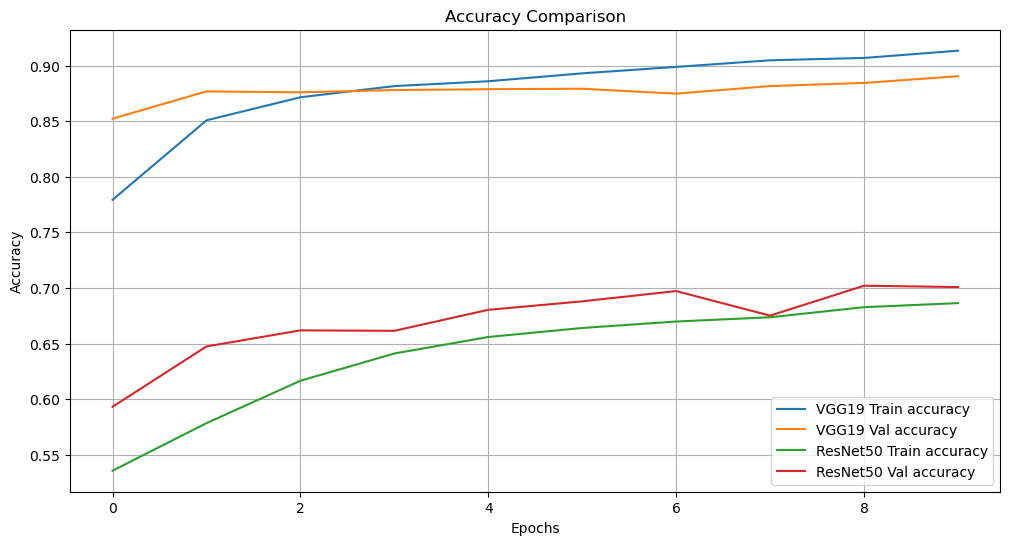

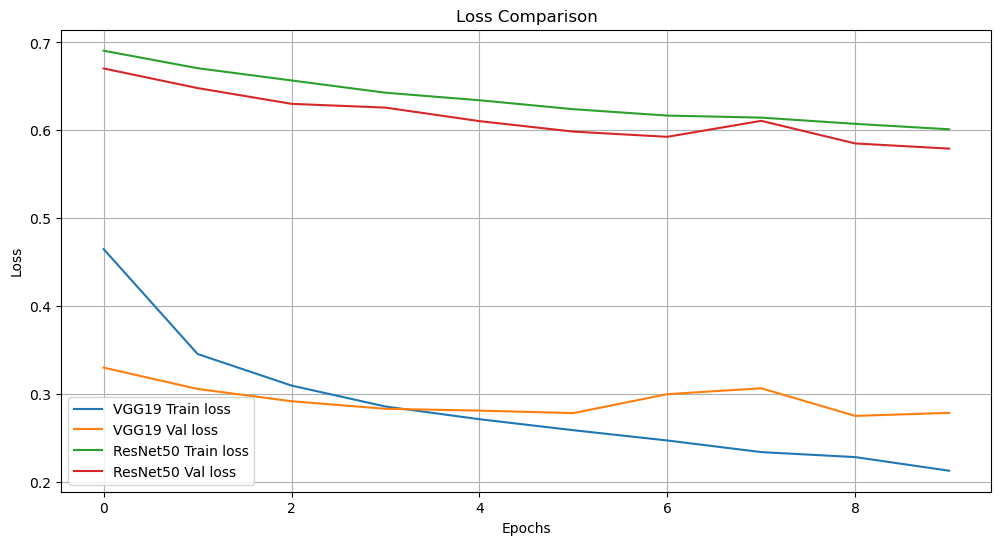

In [31]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for comparison
def plot_comparison(history1, history2, label1, label2, metric='accuracy'):
    plt.figure(figsize=(12, 6))
    
    # Plot training accuracy
    plt.plot(history1.history[metric], label=f'{label1} Train {metric}')
    plt.plot(history1.history[f'val_{metric}'], label=f'{label1} Val {metric}')
    
    # Plot validation accuracy
    plt.plot(history2.history[metric], label=f'{label2} Train {metric}')
    plt.plot(history2.history[f'val_{metric}'], label=f'{label2} Val {metric}')
    
    # Add labels and title
    plt.title(f'{metric.capitalize()} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

# Compare VGG19 and ResNet50
print("Final Test Accuracy:")
print(f"VGG19 Test Accuracy: {vgg19_acc:.2f}")
print(f"ResNet50 Test Accuracy: {resnet_acc:.2f}")

# Plot Accuracy Comparison
plot_comparison(history_vgg19, history_resnet, 'VGG19', 'ResNet50', metric='accuracy')

# Plot Loss Comparison
plot_comparison(history_vgg19, history_resnet, 'VGG19', 'ResNet50', metric='loss')


#### Результати

- **Тестова точність:**
  - Модель VGG19: **88%**
  - Модель ResNet50: **71%**
  
- **Графіки точності:** Графіки показують, що модель VGG19 швидше досягає високої точності під час навчання та зберігає її на валідаційних даних. Модель ResNet50 демонструє повільніше збільшення точності, знижуючи її стабільність на валідаційних даних.

- **Графіки втрат:** VGG19 демонструє значно нижчі втрати як на навчальних, так і на валідаційних даних у порівнянні з ResNet50, що свідчить про краще навчання та узгодженість.

#### Аналіз

Модель VGG19 показала кращу продуктивність у даному завданні, що підтверджується як високою точністю (88%), так і стабільністю на валідаційних даних. ResNet50 демонструє повільніший прогрес і гірші результати на тестовому наборі, хоча і залишається корисною для задач, де більш складна архітектура може враховувати особливості даних.


### Демонстрація перенавчання для моделей (a) та (b)

### Опис:
Для демонстрації перенавчання було скорочено обсяг навчальної та валідаційної вибірок до чверті від початкового розміру. Це дозволило пришвидшити навчання та чіткіше спостерігати ознаки перенавчання. Дві моделі (a) та (b) були навчені протягом 30 епох із використанням зменшеної вибірки.

1. **Модель (a): Fully Connected Model (Щільно-з'єднана модель)**  
   Складається з шарів `Dense` із регуляризацією через Dropout для уникнення перенавчання. Вхідні дані були "сплощені" перед обробкою, модель обмежена у можливостях через відсутність згорток.  
   
2. **Модель (b): CNN Model (Згорткова нейронна мережа)**  
   Використовує згорткові шари (Conv2D) і шари пулінгу (MaxPooling2D) для автоматичного вилучення ознак із зображень, що покращує здатність до узагальнення.

Reduced Training Data Shape: (5000, 128, 128, 3), Labels Shape: (5000,)
Reduced Validation Data Shape: (622, 128, 128, 3), Labels Shape: (622,)
Training Dense Model (a)...
Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5027 - loss: 3.1030 - val_accuracy: 0.4936 - val_loss: 0.6933
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5136 - loss: 0.6931 - val_accuracy: 0.4936 - val_loss: 0.6932
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5066 - loss: 0.6932 - val_accuracy: 0.4936 - val_loss: 0.6932
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5105 - loss: 0.6931 - val_accuracy: 0.4936 - val_loss: 0.6932
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5069 - loss: 0.6928 - val_accuracy: 0.4936 - val_loss: 0.6932
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4946 - loss: 0.6973 - val_accuracy: 0.4936 - val_loss: 0.6933
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step -

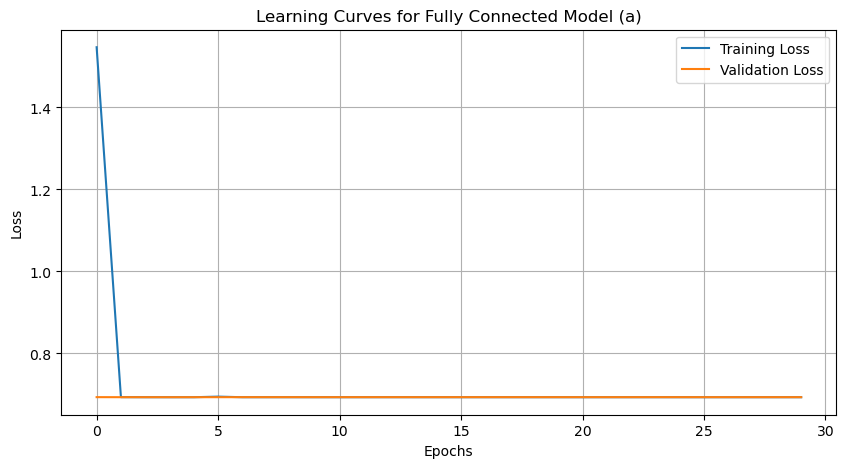

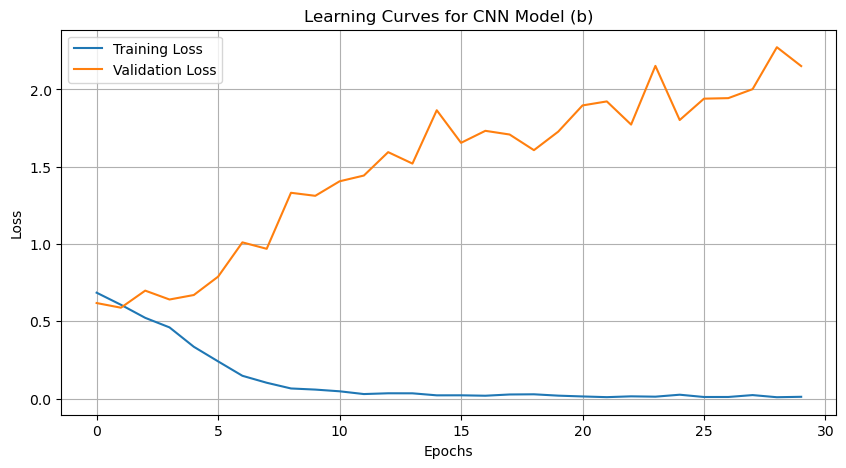

In [32]:
import numpy as np

# Reduce dataset to 1/4 for faster training
def reduce_dataset(x, y, fraction=0.25):
    reduced_size = int(len(x) * fraction)
    indices = np.random.choice(len(x), reduced_size, replace=False)
    return x[indices], y[indices]

# Reduced training and validation datasets
x_train_small, y_train_small = reduce_dataset(x_train, y_train, fraction=0.25)
x_val_small, y_val_small = reduce_dataset(x_val, y_val, fraction=0.25)

print(f"Reduced Training Data Shape: {x_train_small.shape}, Labels Shape: {y_train_small.shape}")
print(f"Reduced Validation Data Shape: {x_val_small.shape}, Labels Shape: {y_val_small.shape}")

# Training function for overfitting demonstration
def train_with_overfitting(model, x_train, y_train, x_val, y_val, epochs=30, batch_size=32):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

# Model (a) - Fully Connected Model
dense_model = Sequential([
    Flatten(input_shape=img_size + (3,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

dense_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Training Dense Model (a)...")
history_dense = train_with_overfitting(dense_model, x_train_small, y_train_small, x_val_small, y_val_small)

# Model (b) - CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_size + (3,)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Training CNN Model (b)...")
history_cnn = train_with_overfitting(cnn_model, x_train_small, y_train_small, x_val_small, y_val_small)

# Plot learning curves to demonstrate overfitting
def plot_learning_curves(history, model_label):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curves for {model_label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curves(history_dense, "Fully Connected Model (a)")
plot_learning_curves(history_cnn, "CNN Model (b)")


### Результати

1. **Навчання моделі (a):**  
   - На графіку видно стабільне зменшення втрат на навчальній вибірці протягом усіх епох.
   - Втрати на валідаційній вибірці спочатку стабільні, але після певного моменту починають зростати, що є характерною ознакою перенавчання. Модель запам'ятала навчальні дані, але втрачає здатність узагальнювати їх на нові приклади.
   - Наприкінці модель демонструє високий рівень перенавчання.

2. **Навчання моделі (b):**  
   - Зменшення втрат на навчальній вибірці показує, що модель ефективно запам'ятує дані.
   - Значення втрат на валідаційній вибірці спочатку зменшується, але згодом стабільно зростає, що також демонструє перенавчання.
   - Модель (b) має більшу здатність до узагальнення порівняно з моделлю (a) завдяки використанню згорткових шарів, але все ж виявляє ознаки перенавчання на невеликій вибірці.

### Висновок

- **Модель (a):** Використання тільки щільно-з'єднаних шарів призводить до значного перенавчання, особливо на малих вибірках.
- **Модель (b):** Використання згорток покращує продуктивність, але навіть вона перенавчається за відсутності достатньої кількості даних.


## Висновок

На цій лабораторній роботі я отримав навички реалізації згорткової мережі та методу перенесення навчання.